In [2]:
# Enable autoreload - automatically reloads modules when they change
%load_ext autoreload
%autoreload 2 

import numpy as np

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column


import numpy as np
from astropy.table import vstack
import torch

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid
import math
import copy
import warnings
import pickle

from itertools import cycle



In [3]:
project_dir_path = "/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/"
temp_files_path = project_dir_path+'TempFiles/'
dataset_name = 'traintest_data5.pkl'


In [4]:
# ==============================================================================
# DIAGNOSE GRADIENT EXPLOSIONS - CHECK FOR BAD DATA
# ==============================================================================

import torch
import pickle
import numpy as np

# Load data
with open(temp_files_path + dataset_name, 'rb') as f:
    X_train, X_test, period_train, period_test, y_train, y_test, feature_cols, train_cluster_names, test_cluster_names = pickle.load(f)

print('='*70)
print('🔍 GRADIENT EXPLOSION DIAGNOSTIC')
print('='*70)

# Check NaN/Inf
print('\n1️⃣  NaN/Inf Check:')
X_nan = torch.isnan(X_train).any().item()
X_inf = torch.isinf(X_train).any().item()
period_nan = torch.isnan(period_train).any().item()
period_inf = torch.isinf(period_train).any().item()
y_nan = torch.isnan(y_train).any().item()
y_inf = torch.isinf(y_train).any().item()

print(f'   X_train NaN: {X_nan}, Inf: {X_inf}')
print(f'   period_train NaN: {period_nan}, Inf: {period_inf}')
print(f'   y_train NaN: {y_nan}, Inf: {y_inf}')

if X_nan or X_inf or period_nan or period_inf or y_nan or y_inf:
    print('   ❌ FOUND NaN/Inf - THIS IS THE PROBLEM!')
else:
    print('   ✅ No NaN/Inf found')

# Check value ranges
print('\n2️⃣  Value Ranges:')
print(f'   X_train: [{X_train.min():.2e}, {X_train.max():.2e}]')
print(f'   period_train: [{period_train.min():.2e}, {period_train.max():.2e}]')
print(f'   y_train: [{y_train.min():.2e}, {y_train.max():.2e}]')

# Check for extreme outliers in periodogram (most likely culprit)
print('\n3️⃣  Periodogram Outlier Analysis:')
period_max_per_sample = period_train.max(dim=1)[0]
period_mean_per_sample = period_train.mean(dim=1)

print(f'\n   Max values per sample (peak strength):')
print(f'     Mean: {period_max_per_sample.mean():.2f}')
print(f'     Std: {period_max_per_sample.std():.2f}')
print(f'     Range: [{period_max_per_sample.min():.2f}, {period_max_per_sample.max():.2f}]')

# Find 10-sigma outliers
mean_max = period_max_per_sample.mean()
std_max = period_max_per_sample.std()
outliers_10sig = torch.abs(period_max_per_sample - mean_max) > 10 * std_max

if outliers_10sig.any():
    print(f'\n   ⚠️  EXTREME OUTLIERS (>10σ): {outliers_10sig.sum()} samples')
    outlier_indices = torch.where(outliers_10sig)[0]
    for idx in outlier_indices:
        z_score = (period_max_per_sample[idx] - mean_max) / std_max
        print(f'     Sample {idx}: peak={period_max_per_sample[idx]:.2f} ({z_score:.1f}σ), cluster={train_cluster_names[idx]}')

# Also check 5-sigma outliers
outliers_5sig = torch.abs(period_max_per_sample - mean_max) > 5 * std_max
print(f'\n   Moderate outliers (>5σ): {outliers_5sig.sum()} samples')

# Check each feature column for outliers
print('\n4️⃣  Summary Stats Outlier Analysis:')
extreme_samples = set()
for i, col in enumerate(feature_cols):
    values = X_train[:, i]
    mean = values.mean()
    std = values.std()
    outliers = torch.abs(values - mean) > 10 * std
    
    if outliers.any():
        print(f'   ⚠️  {col}: {outliers.sum()} extreme outliers (>10σ)')
        for idx in torch.where(outliers)[0]:
            extreme_samples.add(idx.item())
            if idx < 5:  # Show first few
                print(f'       Sample {idx}: value={values[idx]:.2e}, cluster={train_cluster_names[idx]}')

if extreme_samples:
    print(f'\n   Total unique samples with extreme outliers: {len(extreme_samples)}')

# RECOMMENDATIONS
print('\n' + '='*70)
print('💡 RECOMMENDATIONS:')
print('='*70)

if X_nan or X_inf or period_nan or period_inf or y_nan or y_inf:
    print('\n❌ CRITICAL: Remove NaN/Inf values immediately!')
    print('   These WILL cause gradient explosions.')

if outliers_10sig.any() or extreme_samples:
    print('\n⚠️  Found extreme outliers that may cause gradient issues.')
    print('   Options:')
    print('   1. Remove these samples (if they\'re errors)')
    print('   2. Cap outliers (winsorization): clip to mean ± 5σ')
    print('   3. Log-transform periodograms to reduce range')
    print('   4. Investigate if they\'re real clusters with unusual properties')
    
print('\n✅ If no issues found above, the problem may be:')
print('   - Learning rate too high (try lr=1e-4 instead of 3e-4)')
print('   - Numerical instability in the model')

print('='*70)

🔍 GRADIENT EXPLOSION DIAGNOSTIC

1️⃣  NaN/Inf Check:
   X_train NaN: False, Inf: False
   period_train NaN: False, Inf: False
   y_train NaN: False, Inf: False
   ✅ No NaN/Inf found

2️⃣  Value Ranges:
   X_train: [2.88e-05, 4.55e+02]
   period_train: [2.13e-07, 9.02e-01]
   y_train: [6.40e+00, 1.01e+01]

3️⃣  Periodogram Outlier Analysis:

   Max values per sample (peak strength):
     Mean: 0.19
     Std: 0.19
     Range: [0.00, 0.90]

   Moderate outliers (>5σ): 0 samples

4️⃣  Summary Stats Outlier Analysis:
   ⚠️  von_neumann_ratio: 2 extreme outliers (>10σ)
   ⚠️  J_Stetson: 5 extreme outliers (>10σ)
   ⚠️  ratio_of_power_at_high_v_low_freq: 8 extreme outliers (>10σ)
   ⚠️  SumLSP_1_p5_Day_Power: 1 extreme outliers (>10σ)

   Total unique samples with extreme outliers: 16

💡 RECOMMENDATIONS:

⚠️  Found extreme outliers that may cause gradient issues.
   Options:
   1. Remove these samples (if they're errors)
   2. Cap outliers (winsorization): clip to mean ± 5σ
   3. Log-transfor

In [5]:
import numpy as np

print('='*70)
print('📊 FEATURE-BY-FEATURE OUTLIER ANALYSIS')
print('='*70)

Z_EXTREME = 5.0
Z_MODERATE = 3.0
TOPK = 100          # show up to 10 worst offenders
MAX_LIST = 100      # hard cap on how many indices to list (safety for huge sets)

for i, col in enumerate(feature_cols):
    # If X_train is torch tensor, this keeps it safe
    values = X_train[:, i].detach().cpu().numpy()

    vmin, vmax = values.min(), values.max()
    mean, std = values.mean(), values.std()

    print(f'\n{col}:')
    print(f'  Range: [{vmin:.2e}, {vmax:.2e}]')
    print(f'  Mean:  {mean:.2e}, Std: {std:.2e}')

    if std <= 0 or not np.isfinite(std):
        print('  (std is zero or non-finite; skipping z-score check)')
        continue

    z_scores = np.abs((values - mean) / std)
    max_z = np.nanmax(z_scores)

    # Counts
    n_extreme = int(np.sum(z_scores > Z_EXTREME))
    n_moderate = int(np.sum(z_scores > Z_MODERATE))

    if max_z > Z_EXTREME:
        print(f'  ⚠️  EXTREME OUTLIERS: {n_extreme} samples > {Z_EXTREME:.0f}σ '
              f'({n_moderate} samples > {Z_MODERATE:.0f}σ)')

        # Indices of all extreme outliers
        extreme_idx = np.where(z_scores > Z_EXTREME)[0]

        # Sort those indices by z-score descending
        extreme_idx_sorted = extreme_idx[np.argsort(z_scores[extreme_idx])[::-1]]

        # Show top offenders
        show_idx = extreme_idx_sorted[:min(TOPK, len(extreme_idx_sorted), MAX_LIST)]

        print(f'     Top {len(show_idx)} worst:')
        for j, idx in enumerate(show_idx, start=1):
            cluster = train_cluster_names[idx] if train_cluster_names is not None else "N/A"
            print(f'       {j:>2d}) sample {idx:>6d}  '
                  f'value={values[idx]: .2e}  z={z_scores[idx]:5.1f}σ  cluster={cluster}')

        # If there are more, don’t spam the notebook
        remaining = len(extreme_idx_sorted) - len(show_idx)
        if remaining > 0:
            print(f'     ... and {remaining} more > {Z_EXTREME:.0f}σ')

    elif max_z > Z_MODERATE:
        print(f'  ⚠️  Moderate outliers: max z-score = {max_z:.1f}σ '
              f'({n_moderate} samples > {Z_MODERATE:.0f}σ)')

print('\n' + '='*70)
print('💡 RECOMMENDATION:')
print('='*70)
print('\nThe features with extreme outliers (>10σ) are causing gradient explosions.')
print('\nOptions:')
print('1. Log-transform those features: X_new = log(abs(X) + 1) * sign(X)')
print('2. Winsorize: Cap values at mean ± 5σ before training')
print('3. Remove samples with extreme outliers')
print('4. Use RobustScaler instead of StandardScaler (less sensitive to outliers)')
print('='*70)

📊 FEATURE-BY-FEATURE OUTLIER ANALYSIS

rms:
  Range: [1.62e-02, 3.75e-01]
  Mean:  1.19e-01, Std: 7.92e-02
  ⚠️  Moderate outliers: max z-score = 3.2σ (4 samples > 3σ)

std:
  Range: [4.28e-05, 9.54e-03]
  Mean:  9.87e-04, Std: 9.64e-04
  ⚠️  EXTREME OUTLIERS: 18 samples > 5σ (115 samples > 3σ)
     Top 18 worst:
        1) sample   1129  value= 9.54e-03  z=  8.9σ  cluster=NGC1704
        2) sample   1121  value= 9.38e-03  z=  8.7σ  cluster=NGC1704
        3) sample   1109  value= 8.95e-03  z=  8.3σ  cluster=NGC1704
        4) sample   1131  value= 8.41e-03  z=  7.7σ  cluster=NGC1704
        5) sample   1125  value= 8.10e-03  z=  7.4σ  cluster=NGC1704
        6) sample   1119  value= 7.87e-03  z=  7.1σ  cluster=NGC1704
        7) sample   1106  value= 7.40e-03  z=  6.7σ  cluster=NGC1704
        8) sample   1123  value= 7.29e-03  z=  6.5σ  cluster=NGC1704
        9) sample   1115  value= 6.96e-03  z=  6.2σ  cluster=NGC1704
       10) sample   1073  value= 6.85e-03  z=  6.1σ  cluster=NGC

Target cluster: NGC 2910 (8 samples)


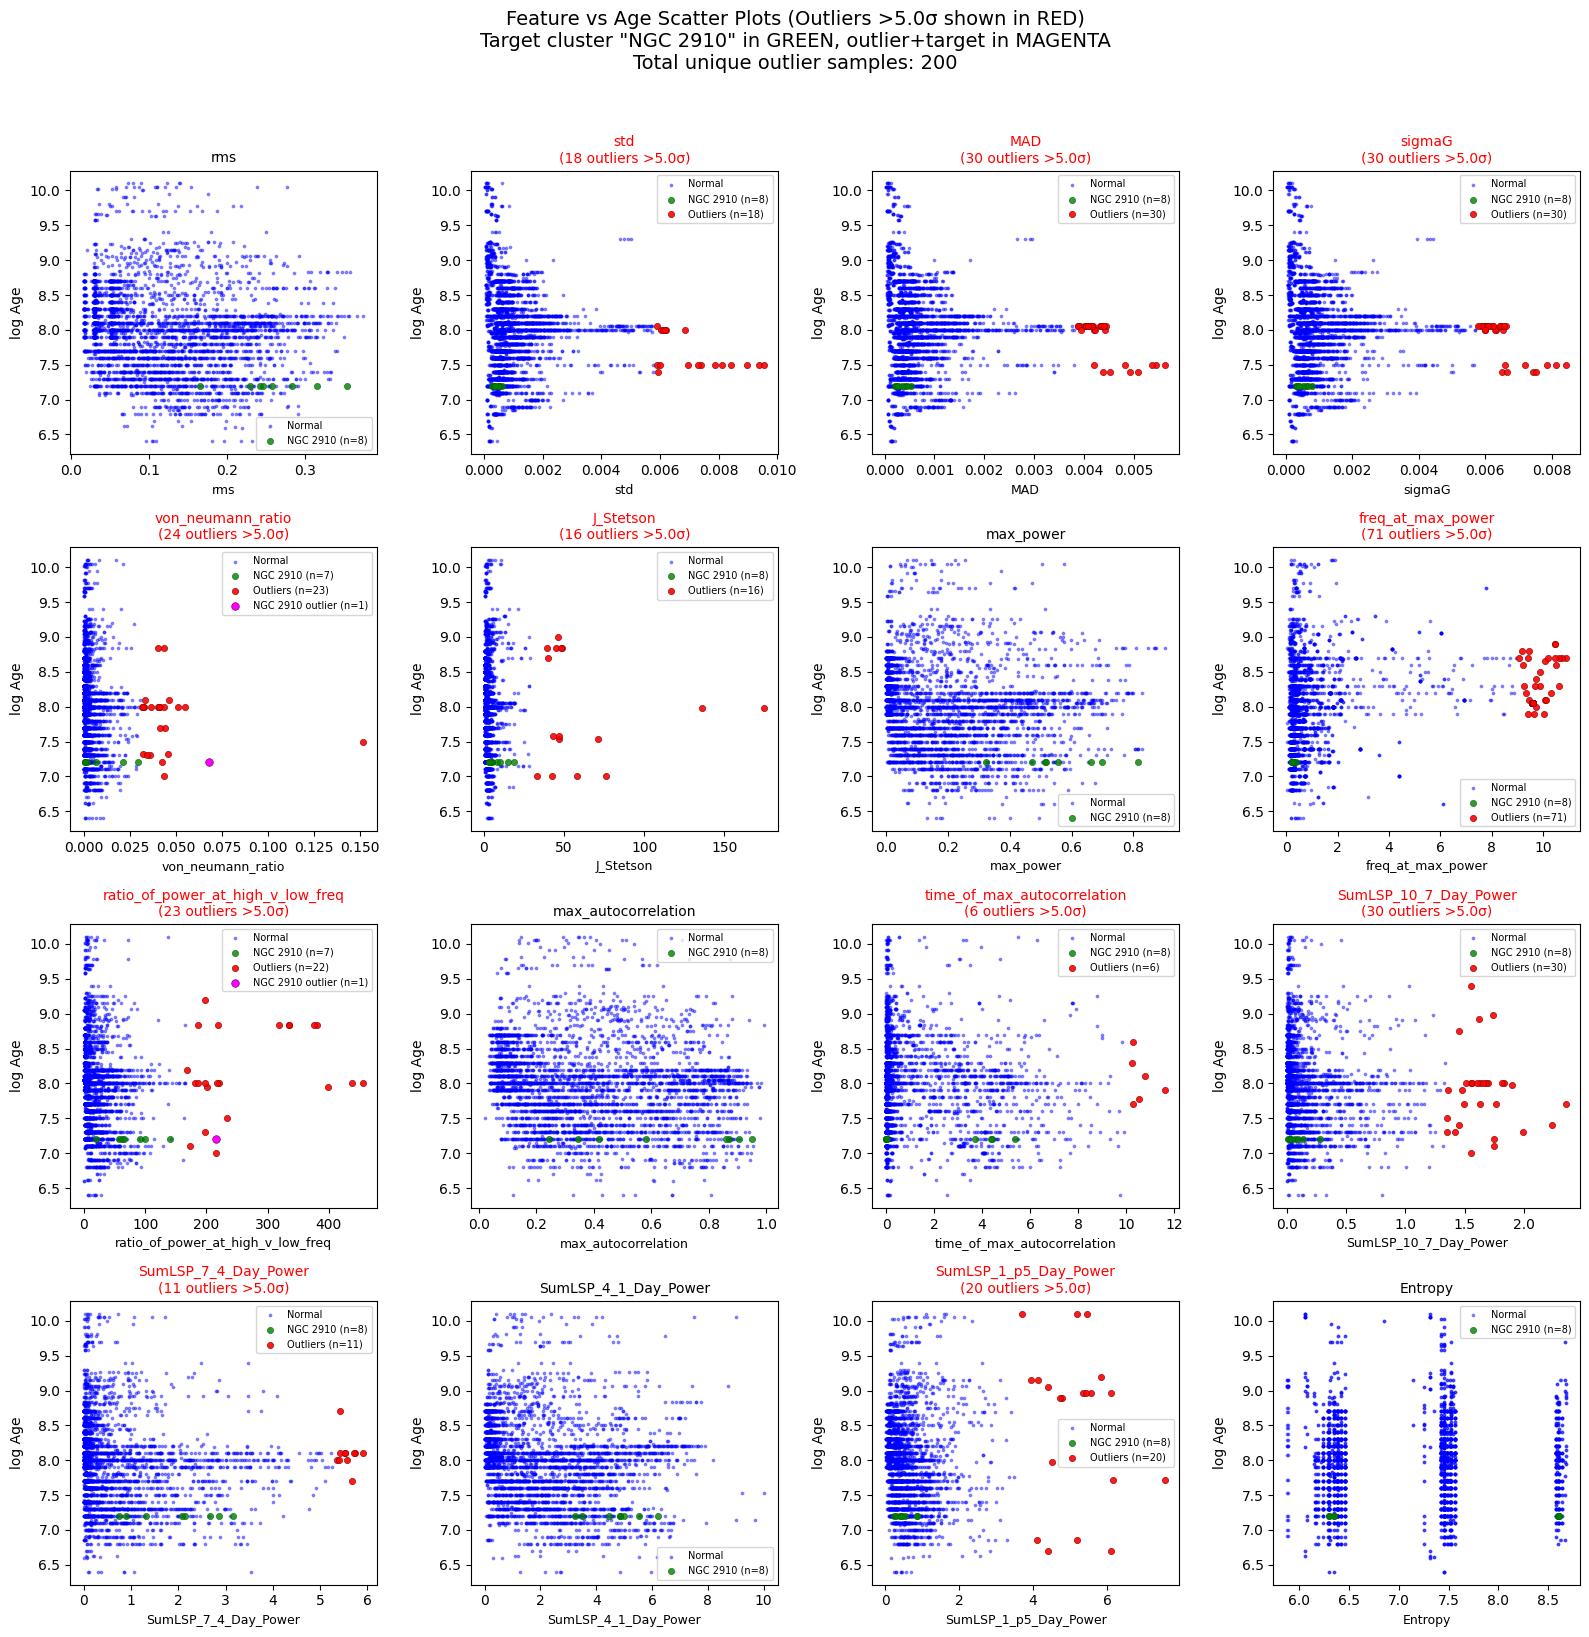


OUTLIER SUMMARY (>5.0σ)
Total unique samples with outliers: 200

Outlier sample indices and their clusters:
  Sample     5 | cluster=ASCC 116             | outlier in: ratio_of_power_at_high_v_low_freq(6.1σ)
  Sample     7 | cluster=ASCC 116             | outlier in: ratio_of_power_at_high_v_low_freq(12.7σ)
  Sample    14 | cluster=ASCC 8               | outlier in: time_of_max_autocorrelation(5.3σ)
  Sample    18 | cluster=ASCC 9               | outlier in: J_Stetson(5.7σ)
  Sample    19 | cluster=ASCC 9               | outlier in: von_neumann_ratio(7.2σ), J_Stetson(7.4σ), ratio_of_power_at_high_v_low_freq(6.6σ), SumLSP_10_7_Day_Power(5.9σ)
  Sample    24 | cluster=BASEL 12             | outlier in: SumLSP_10_7_Day_Power(6.1σ)
  Sample   186 | cluster=COLLINDER 62         | outlier in: freq_at_max_power(5.9σ)
  Sample   187 | cluster=COLLINDER 62         | outlier in: freq_at_max_power(5.9σ)
  Sample   188 | cluster=CZERNIK 13           | outlier in: SumLSP_1_p5_Day_Power(6.0σ)
  Sam

In [17]:
# ====================
# VISUALIZE OUTLIERS
# ====================

import matplotlib.pyplot as plt
import numpy as np

# Configuration
Z_THRESHOLD = 5.0  # z-score threshold for outliers
#target_cluster_name = 'NGC1704'  # Set to a cluster name (e.g., 'NGC_2516') to highlight it in green
                                 # Points that are both outliers AND in target cluster will be magenta
                                 # Set to None for default behavior (blue=normal, red=outlier)
target_cluster_name = '[SL63] 410'
target_cluster_name = 'NGC1932'
target_cluster_name = '[SL63] 106'
target_cluster_name = 'NGC 129'
target_cluster_name = 'IC 2581'
target_cluster_name = '[SL63] 763'
target_cluster_name = 'BSDL1674'
target_cluster_name = 'NGC2000'

target_cluster_name = 'NGC2003'
target_cluster_name = '[SL63] 502'
target_cluster_name = 'NGC 2910'

# Convert to numpy for plotting
X_np = X_train.detach().cpu().numpy()
y_np = y_train.detach().cpu().numpy()

# Create target cluster mask if specified
if target_cluster_name is not None:
    target_cluster_mask = np.array([name == target_cluster_name for name in train_cluster_names])
    n_target_samples = target_cluster_mask.sum()
    print(f'Target cluster: {target_cluster_name} ({n_target_samples} samples)')
else:
    target_cluster_mask = None

# Setup grid layout
n_features = len(feature_cols)
ncols = 4
nrows = int(np.ceil(n_features / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
axs = axs.flatten()

# Track all outlier indices across features
all_outlier_indices = set()

for i, col in enumerate(feature_cols):
    ax = axs[i]
    values = X_np[:, i]

    # Compute z-scores
    mean = values.mean()
    std = values.std()

    if std > 0:
        z_scores = np.abs((values - mean) / std)
        outlier_mask = z_scores > Z_THRESHOLD
        normal_mask = ~outlier_mask

        # Track outlier indices
        outlier_indices = np.where(outlier_mask)[0]
        all_outlier_indices.update(outlier_indices)

        n_outliers = outlier_mask.sum()
    else:
        normal_mask = np.ones(len(values), dtype=bool)
        outlier_mask = np.zeros(len(values), dtype=bool)
        n_outliers = 0

    if target_cluster_mask is not None:
        # Split into 4 categories:
        # 1. Normal, not target cluster (blue)
        # 2. Normal, target cluster (green)
        # 3. Outlier, not target cluster (red)
        # 4. Outlier AND target cluster (magenta)
        
        normal_not_target = normal_mask & ~target_cluster_mask
        normal_target = normal_mask & target_cluster_mask
        outlier_not_target = outlier_mask & ~target_cluster_mask
        outlier_target = outlier_mask & target_cluster_mask
        
        # Plot in order: blue (back), green, red, magenta (front)
        ax.scatter(values[normal_not_target], y_np[normal_not_target],
                   s=3, alpha=0.4, c='blue', label='Normal')
        
        if normal_target.any():
            ax.scatter(values[normal_target], y_np[normal_target],
                       s=20, alpha=0.8, c='green', edgecolors='darkgreen',
                       linewidths=0.5, label=f'{target_cluster_name} (n={normal_target.sum()})')
        
        if outlier_not_target.any():
            ax.scatter(values[outlier_not_target], y_np[outlier_not_target],
                       s=20, alpha=0.9, c='red', edgecolors='darkred',
                       linewidths=0.5, label=f'Outliers (n={outlier_not_target.sum()})')
        
        if outlier_target.any():
            ax.scatter(values[outlier_target], y_np[outlier_target],
                       s=30, alpha=1.0, c='magenta', edgecolors='purple',
                       linewidths=0.5, label=f'{target_cluster_name} outlier (n={outlier_target.sum()})')
    else:
        # Original behavior: blue for normal, red for outliers
        ax.scatter(values[normal_mask], y_np[normal_mask],
                   s=3, alpha=0.4, c='blue', label='Normal')

        if outlier_mask.any():
            ax.scatter(values[outlier_mask], y_np[outlier_mask],
                       s=20, alpha=0.9, c='red', edgecolors='darkred',
                       linewidths=0.5, label=f'Outliers (n={n_outliers})')

    # Labels and title
    ax.set_xlabel(col, fontsize=9)
    ax.set_ylabel('log Age')

    if n_outliers > 0:
        ax.set_title(f'{col}\n({n_outliers} outliers >{Z_THRESHOLD}σ)', fontsize=10, color='red')
    else:
        ax.set_title(col, fontsize=10)

    # Add legend only if there are outliers or target cluster
    if n_outliers > 0 or target_cluster_mask is not None:
        ax.legend(loc='best', fontsize=7)

# Hide empty subplots
for j in range(n_features, len(axs)):
    axs[j].set_visible(False)

# Build title
if target_cluster_mask is not None:
    title = (f'Feature vs Age Scatter Plots (Outliers >{Z_THRESHOLD}σ shown in RED)\n'
             f'Target cluster "{target_cluster_name}" in GREEN, outlier+target in MAGENTA\n'
             f'Total unique outlier samples: {len(all_outlier_indices)}')
else:
    title = (f'Feature vs Age Scatter Plots (Outliers >{Z_THRESHOLD}σ shown in RED)\n'
             f'Total unique outlier samples: {len(all_outlier_indices)}')

plt.suptitle(title, fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print summary of outlier samples
print(f'\n{"="*70}')
print(f'OUTLIER SUMMARY (>{Z_THRESHOLD}σ)')
print(f'{"="*70}')
print(f'Total unique samples with outliers: {len(all_outlier_indices)}')

if len(all_outlier_indices) > 0:
    print(f'\nOutlier sample indices and their clusters:')
    for idx in sorted(all_outlier_indices)[:30]:  # Show first 30
        # Find which features this sample is an outlier in
        outlier_features = []
        for i, col in enumerate(feature_cols):
            val = X_np[idx, i]
            mean = X_np[:, i].mean()
            std = X_np[:, i].std()
            if std > 0:
                z = abs((val - mean) / std)
                if z > Z_THRESHOLD:
                    outlier_features.append(f'{col}({z:.1f}σ)')

        # Mark if this is a target cluster sample
        target_marker = ' ★' if (target_cluster_mask is not None and target_cluster_mask[idx]) else ''
        print(f'  Sample {idx:>5d} | cluster={train_cluster_names[idx]:20s}{target_marker} | outlier in: {", ".join(outlier_features)}')

Found 200 outlier samples. Plotting first 200.


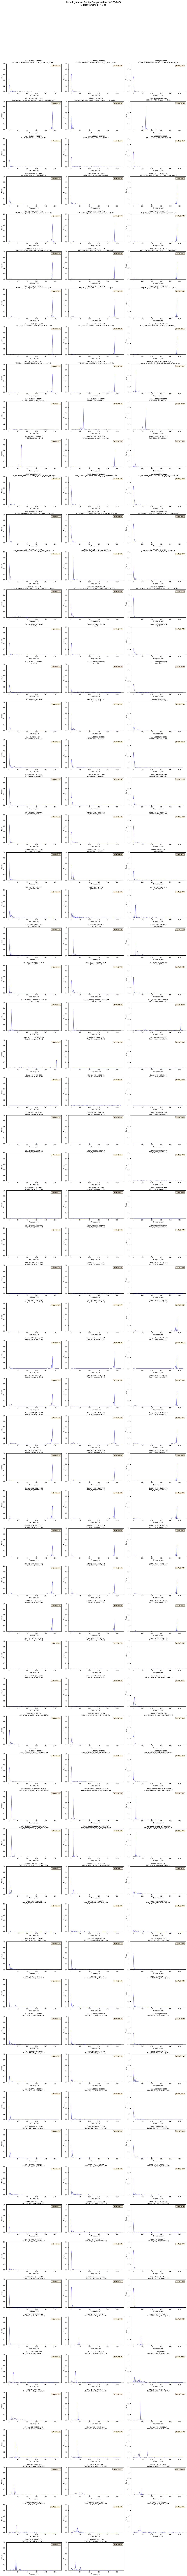


Detailed outlier information:
----------------------------------------------------------------------
 1. Sample  1052 | Age=8.00 | NGC1698              | std(5.4σ), MAD(5.6σ), sigmaG(5.6σ), von_neumann_ratio(9.3σ), SumLSP_10_7_Day_Power(5.9σ)
 2. Sample  1086 | Age=8.00 | NGC1698              | std(5.3σ), MAD(5.9σ), sigmaG(5.8σ), ratio_of_power_at_high_v_low_freq(14.6σ), SumLSP_7_4_Day_Power(5.1σ)
 3. Sample  1073 | Age=8.00 | NGC1698              | std(6.1σ), MAD(5.6σ), sigmaG(5.5σ), ratio_of_power_at_high_v_low_freq(6.8σ)
 4. Sample  3541 | Age=8.05 | [SL63] 410           | std(5.1σ), MAD(5.9σ), sigmaG(5.8σ), freq_at_max_power(5.4σ)
 5. Sample    19 | Age=7.00 | ASCC 9               | von_neumann_ratio(7.2σ), J_Stetson(7.4σ), ratio_of_power_at_high_v_low_freq(6.6σ), SumLSP_10_7_Day_Power(5.9σ)
 6. Sample   517 | Age=7.40 | KMHK1378             | std(5.1σ), MAD(6.9σ), sigmaG(6.8σ)
 7. Sample  1109 | Age=7.50 | NGC1704              | std(8.3σ), MAD(5.5σ), sigmaG(5.8σ)
 8. Sample  1121

In [4]:
# ==============================================================================
# PLOT PERIODOGRAM OF OUTLIERS
# ==============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Configuration
MAX_PLOTS = 200         # Maximum number of periodograms to plot
Z_THRESHOLD = 5.0       # Same threshold as outlier visualization cell

# Recompute outlier indices (in case this cell is run independently)
X_np = X_train.detach().cpu().numpy()
period_np = period_train.detach().cpu().numpy()
y_np = y_train.detach().cpu().numpy().flatten()  # Flatten to 1D

# Find all outlier indices and their outlier features
outlier_info = {}  # {sample_idx: [list of (feature_name, z_score)]}

for i, col in enumerate(feature_cols):
    values = X_np[:, i]
    mean = values.mean()
    std = values.std()
    
    if std > 0:
        z_scores = np.abs((values - mean) / std)
        outlier_indices = np.where(z_scores > Z_THRESHOLD)[0]
        
        for idx in outlier_indices:
            if idx not in outlier_info:
                outlier_info[idx] = []
            outlier_info[idx].append((col, z_scores[idx]))

# Sort by number of outlier features (most problematic first)
sorted_outliers = sorted(outlier_info.keys(), 
                         key=lambda x: len(outlier_info[x]), 
                         reverse=True)

n_outliers = len(sorted_outliers)
n_plots = min(MAX_PLOTS, n_outliers)

print(f'Found {n_outliers} outlier samples. Plotting first {n_plots}.')
print('='*70)

if n_plots == 0:
    print('No outliers to plot!')
else:
    # Determine grid size
    ncols = 3
    nrows = int(np.ceil(n_plots / ncols))
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows))
    axs = np.atleast_1d(axs).flatten()
    
    for plot_idx, sample_idx in enumerate(sorted_outliers[:n_plots]):
        ax = axs[plot_idx]
        
        # Get periodogram data
        periodogram = period_np[sample_idx]
        
        # Plot periodogram
        ax.plot(periodogram, linewidth=0.5, color='blue', alpha=0.8)
        
        # Get cluster name and outlier features
        cluster_name = train_cluster_names[sample_idx]
        outlier_features = outlier_info[sample_idx]
        
        # Format outlier features string (truncate if too long)
        feat_str = ', '.join([f'{f}({z:.1f}σ)' for f, z in outlier_features])
        if len(feat_str) > 60:
            feat_str = feat_str[:57] + '...'
        
        # Title with sample info
        ax.set_title(f'Sample {sample_idx} | {cluster_name}\n{feat_str}', 
                     fontsize=8, wrap=True)
        ax.set_xlabel('Frequency bin', fontsize=8)
        ax.set_ylabel('Power', fontsize=8)
        ax.tick_params(axis='both', labelsize=7)
        
        # Highlight the age value
        age = float(y_np[sample_idx])
        ax.text(0.98, 0.95, f'log(Age)={age:.2f}', 
                transform=ax.transAxes, fontsize=7,
                ha='right', va='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax.set_ylim([0, 1])
    
    # Hide empty subplots
    for j in range(n_plots, len(axs)):
        axs[j].set_visible(False)
    
    plt.suptitle(f'Periodograms of Outlier Samples (showing {n_plots}/{n_outliers})\n'
                 f'Outlier threshold: >{Z_THRESHOLD}σ',
                 fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

# Print detailed outlier info
print(f'\nDetailed outlier information:')
print('-'*70)
for i, sample_idx in enumerate(sorted_outliers[:MAX_PLOTS]):
    cluster = train_cluster_names[sample_idx]
    age = float(y_np[sample_idx])
    features = outlier_info[sample_idx]
    feat_str = ', '.join([f'{f}({z:.1f}σ)' for f, z in features])
    print(f'{i+1:2d}. Sample {sample_idx:>5d} | Age={age:.2f} | {cluster:20s} | {feat_str}')

In [11]:
# ==============================================================================
# VISUALIZE SKEWNESS DISTRIBUTION
# ==============================================================================

import matplotlib.pyplot as plt

# Find skewness column index
skew_idx = feature_cols.index('skewness')
skew_values = X_train[:, skew_idx].numpy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Full histogram (log scale to see outliers)
ax1 = axes[0, 0]
ax1.hist(skew_values, bins=100, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Skewness')
ax1.set_ylabel('Count')
ax1.set_title('Skewness Distribution (Full Range)')
ax1.set_yscale('log')
ax1.axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoomed in to reasonable range [-10, +10]
ax2 = axes[0, 1]
reasonable_mask = np.abs(skew_values) <= 10
if reasonable_mask.any():
    ax2.hist(skew_values[reasonable_mask], bins=50, edgecolor='black', alpha=0.7, color='green')
    ax2.set_xlabel('Skewness')
    ax2.set_ylabel('Count')
    ax2.set_title(f'Skewness Distribution (|skew| ≤ 10)\n{reasonable_mask.sum()}/{len(skew_values)} samples')
    ax2.axvline(0, color='red', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)

# Zoomed in to extreme outliers
ax3 = axes[1, 0]
extreme_mask = np.abs(skew_values) > 10
if extreme_mask.any():
    ax3.hist(skew_values[extreme_mask], bins=50, edgecolor='black', alpha=0.7, color='red')
    ax3.set_xlabel('Skewness')
    ax3.set_ylabel('Count')
    ax3.set_title(f'Extreme Outliers (|skew| > 10)\n{extreme_mask.sum()}/{len(skew_values)} samples')
    ax3.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax3.grid(True, alpha=0.3)

# Statistics box
ax4 = axes[1, 1]
ax4.axis('off')
stats_text = f'''
Skewness Statistics:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Total samples:        {len(skew_values)}
Min:                  {skew_values.min():.2e}
Max:                  {skew_values.max():.2e}
Mean:                 {skew_values.mean():.2e}
Median:               {np.median(skew_values):.2e}
Std:                  {skew_values.std():.2e}

Distribution:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
|skew| ≤ 3:           {(np.abs(skew_values) <= 3).sum()} ({(np.abs(skew_values) <= 3).sum()/len(skew_values)*100:.1f}%)
|skew| ≤ 10:          {(np.abs(skew_values) <= 10).sum()} ({(np.abs(skew_values) <= 10).sum()/len(skew_values)*100:.1f}%)
|skew| > 10:          {(np.abs(skew_values) > 10).sum()} ({(np.abs(skew_values) > 10).sum()/len(skew_values)*100:.1f}%)
|skew| > 100:         {(np.abs(skew_values) > 100).sum()} ({(np.abs(skew_values) > 100).sum()/len(skew_values)*100:.1f}%)
|skew| > 1000:        {(np.abs(skew_values) > 1000).sum()} ({(np.abs(skew_values) > 1000).sum()/len(skew_values)*100:.1f}%)
|skew| > 1e6:         {(np.abs(skew_values) > 1e6).sum()} ({(np.abs(skew_values) > 1e6).sum()/len(skew_values)*100:.1f}%)

💡 Recommendation:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Normal skewness: -3 to +3
Cap to [-10, +10] to fix gradient explosions
'''
ax4.text(0.1, 0.5, stats_text, fontsize=10, family='monospace', 
         verticalalignment='center', transform=ax4.transAxes)

plt.tight_layout()
plt.show()

# Print extreme samples
print('\n🔍 Samples with extreme skewness:')
extreme_indices = np.where(np.abs(skew_values) > 100)[0]
if len(extreme_indices) > 0:
    print(f'Found {len(extreme_indices)} samples with |skewness| > 100:')
    for idx in extreme_indices[:20]:  # Show first 20
        print(f'  Sample {idx}: skewness={skew_values[idx]:.2e}, cluster={train_cluster_names[idx]}')

ValueError: 'skewness' is not in list

In [ ]:
# ==============================================================================
# REMOVE OUTLIERS AND SAVE CLEANED DATASET
# ==============================================================================

import pickle
import numpy as np
import torch

# =========================
# CONFIGURATION
# =========================
REMOVE_MODE = 'samples'    # 'samples' = remove only outlier samples
                           # 'clusters' = remove ALL samples from clusters containing outliers
Z_THRESHOLD = 5.0          # Same threshold as visualization cells
DATASET_NAME = 'traintest_data5'  # Base name (will save as DATASET_NAME_v2.pkl)

# =========================
# Recompute outlier indices
# =========================
X_np = X_train.detach().cpu().numpy()

outlier_indices = set()
for i, col in enumerate(feature_cols):
    values = X_np[:, i]
    mean = values.mean()
    std = values.std()
    
    if std > 0:
        z_scores = np.abs((values - mean) / std)
        feature_outliers = np.where(z_scores > Z_THRESHOLD)[0]
        outlier_indices.update(feature_outliers)

outlier_indices = sorted(outlier_indices)
print(f'Found {len(outlier_indices)} outlier samples (>{Z_THRESHOLD}σ)')

# =========================
# Determine samples to remove
# =========================
if REMOVE_MODE == 'samples':
    # Remove only the specific outlier samples
    remove_indices = set(outlier_indices)
    print(f'\nMode: SAMPLES - Removing {len(remove_indices)} individual samples')
    
elif REMOVE_MODE == 'clusters':
    # Find clusters containing outliers, then remove ALL samples from those clusters
    outlier_clusters = set(train_cluster_names[idx] for idx in outlier_indices)
    print(f'\nMode: CLUSTERS - Found {len(outlier_clusters)} clusters with outliers:')
    for cluster in sorted(outlier_clusters):
        print(f'  - {cluster}')
    
    # Find all samples belonging to those clusters
    remove_indices = set()
    for idx, cluster in enumerate(train_cluster_names):
        if cluster in outlier_clusters:
            remove_indices.add(idx)
    
    print(f'\nRemoving {len(remove_indices)} samples (all samples from {len(outlier_clusters)} clusters)')
else:
    raise ValueError(f"Invalid REMOVE_MODE: {REMOVE_MODE}. Use 'samples' or 'clusters'")

# =========================
# Create filtered dataset
# =========================
n_original = len(X_train)
keep_mask = np.array([i not in remove_indices for i in range(n_original)])

X_train_clean = X_train[keep_mask]
period_train_clean = period_train[keep_mask]
y_train_clean = y_train[keep_mask]
train_cluster_names_clean = [train_cluster_names[i] for i in range(n_original) if i not in remove_indices]

# Test data remains unchanged
X_test_clean = X_test
period_test_clean = period_test
y_test_clean = y_test
test_cluster_names_clean = test_cluster_names

print(f'\n{"="*70}')
print(f'DATASET SUMMARY')
print(f'{"="*70}')
print(f'Original training samples:  {n_original}')
print(f'Removed samples:            {len(remove_indices)}')
print(f'Remaining training samples: {len(X_train_clean)}')
print(f'Test samples (unchanged):   {len(X_test_clean)}')
print(f'\nOriginal clusters in train: {len(set(train_cluster_names))}')
print(f'Remaining clusters in train: {len(set(train_cluster_names_clean))}')

# =========================
# Save cleaned dataset
# =========================
output_filename = f'{DATASET_NAME}_v2.pkl'
output_path = temp_files_path + output_filename

cleaned_data = (
    X_train_clean, X_test_clean,
    period_train_clean, period_test_clean,
    y_train_clean, y_test_clean,
    feature_cols,
    train_cluster_names_clean, test_cluster_names_clean
)

with open(output_path, 'wb') as f:
    pickle.dump(cleaned_data, f)

print(f'\n{"="*70}')
print(f'SAVED: {output_path}')
print(f'{"="*70}')
print(f'\nTo use the cleaned dataset, update the filename in 1_HyperparamTuning.ipynb:')
print(f"  file_name = '{output_filename}'")